In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_standardised_dataset
from image_standardisation import restore_standardised_image

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

2023-01-24 18:45:28.232737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:45:28.818908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:45:28.818928: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 18:45:30.647708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

In [3]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_standardised_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

In [4]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3)),
      layers.Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='leaky_relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation="tanh", padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-24 18:45:42.733360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-24 18:45:42.733520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:45:42.733587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:45:42.733640: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [6]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [7]:
history = autoencoder.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

2023-01-24 18:45:43.059091: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/10


2023-01-24 18:45:43.231439: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 32s 964ms/step - loss: 0.0905 - kullback_leibler_divergence: 2.2472 - MAE: 0.2418 - val_loss: 0.0323 - val_kullback_leibler_divergence: 1.8122 - val_MAE: 0.1220 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 30s 944ms/step - loss: 0.0322 - kullback_leibler_divergence: 1.8546 - MAE: 0.1109 - val_loss: 0.0208 - val_kullback_leibler_divergence: 0.7095 - val_MAE: 0.0840 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 32s 987ms/step - loss: 0.0180 - kullback_leibler_divergence: 0.3472 - MAE: 0.0799 - val_loss: 0.0098 - val_kullback_leibler_divergence: 0.0368 - val_MAE: 0.0664 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 34s 1s/step - loss: 0.0089 - kullback_leibler_divergence: 0.0859 - MAE: 0.0617 - val_loss: 0.0081 - val_kullback_leibler_divergence: 0.0648 - val_MAE: 0.0598 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 30s 937ms/step - loss: 0.0082 - kullback_leibler_divergenc

In [8]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 128, 128, 8)      584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 16)     1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 3)       435       
                                                                 
Total params: 2,187
Trainable params: 2,187
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.evaluate(test_x, test_y)

4/4 [==============================] - 1s 351ms/step - loss: 0.0072 - kullback_leibler_divergence: 0.0988 - MAE: 0.0577


[0.007154477760195732, 0.09883224219083786, 0.05768531560897827]

In [9]:
encoded_imgs = autoencoder.encoder(test_x).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

2023-01-23 17:17:42.357320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-23 17:17:42.758241: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-23 17:17:42.863679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.


In [10]:
rgb_decoded_imgs = np.array([restore_standardised_image(img) for img in decoded_imgs])

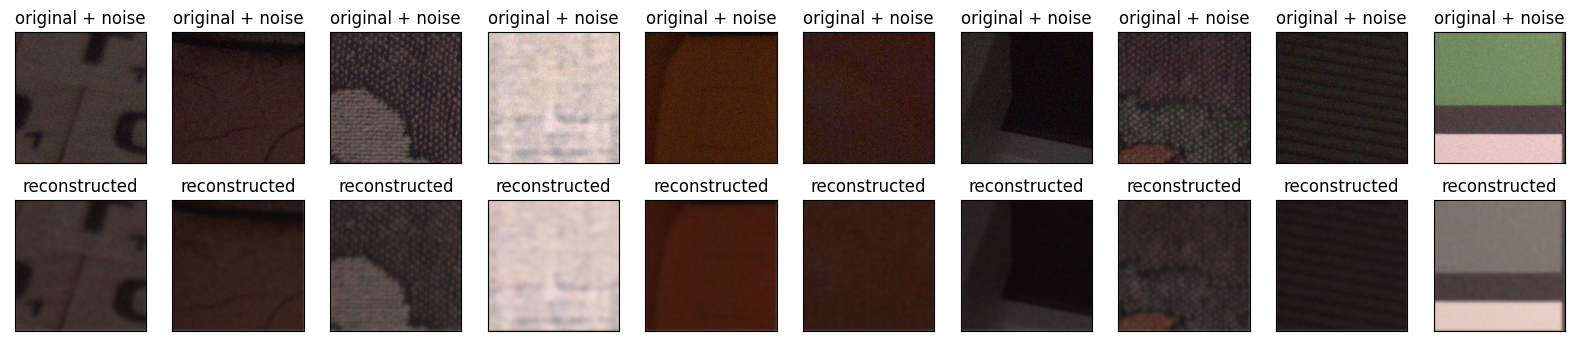

In [11]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(restore_standardised_image(test_x[i])))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(rgb_decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

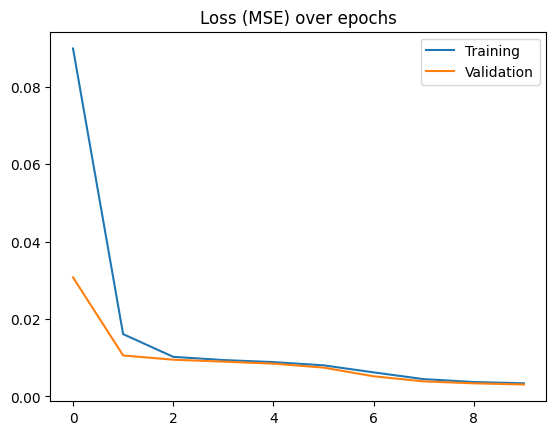

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE) over epochs")
plt.show()

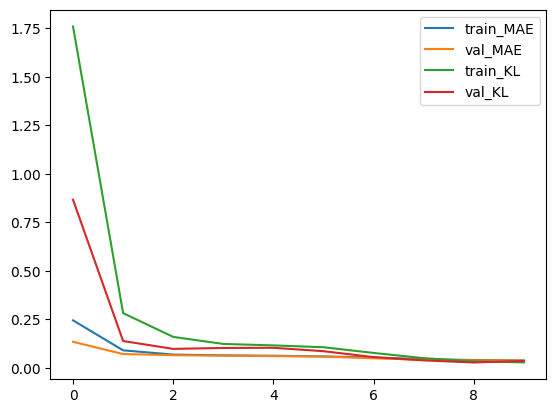

In [36]:
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.plot(history.history["kullback_leibler_divergence"])
plt.plot(history.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.show()


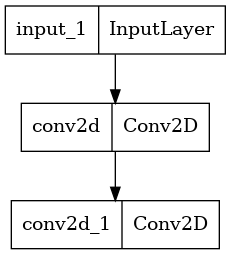

In [16]:
plot_model(autoencoder.encoder)

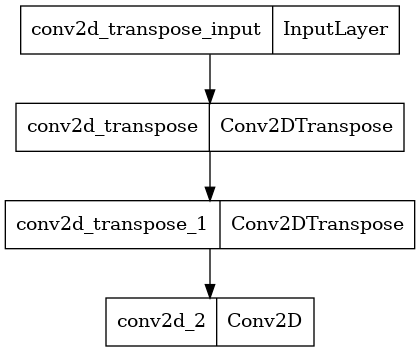

In [15]:
plot_model(autoencoder.decoder)

In [25]:
autoencoder.encoder.save("basic_autoencoder_encoder.h5")
autoencoder.decoder.save("basic_autoencoder_decoder.h5")

In [33]:
import os
# Get file size in bytes for a given model
encoder_bytes = os.stat('basic_autoencoder_encoder.h5').st_size
decoder_bytes = os.stat('basic_autoencoder_decoder.h5').st_size
print(f"Encoder size in memory: {encoder_bytes} B = {encoder_bytes/1024} KiB = {encoder_bytes/1024**2} MiB = {encoder_bytes/1024**3} GiB")
print(f"Decoder size in memory: {decoder_bytes} B = {decoder_bytes/1024} KiB = {decoder_bytes/1024**2} MiB = {decoder_bytes/1024**3} GiB")

Encoder size in memory: 19752 B = 19.2890625 KiB = 0.01883697509765625 MiB = 1.839548349380493e-05 GiB
Decoder size in memory: 25040 B = 24.453125 KiB = 0.0238800048828125 MiB = 2.3320317268371582e-05 GiB


---
## Testing other optimisers

Adagrad

In [7]:
autoencoder_adagrad = Denoise()
autoencoder_adagrad.compile(optimizer='adagrad', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-23 19:44:37.825929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 19:44:37.826086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 19:44:37.826183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 19:44:37.826239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [8]:
history_adagrad = autoencoder_adagrad.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

2023-01-23 19:44:38.446463: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 19:44:38.737173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/10
32/32 [==============================] - 37s 1s/step - loss: 0.1429 - kullback_leibler_divergence: 1.5468 - MAE: 0.3338 - val_loss: 0.1444 - val_kullback_leibler_divergence: 2.2176 - val_MAE: 0.3362 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.1364 - kullback_leibler_divergence: 1.7208 - MAE: 0.3249 - val_loss: 0.1398 - val_kullback_leibler_divergence: 2.3646 - val_MAE: 0.3294 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 33s 1s/step - loss: 0.1319 - kullback_leibler_divergence: 1.8053 - MAE: 0.3187 - val_loss: 0.1362 - val_kullback_leibler_divergence: 2.4617 - val_MAE: 0.3239 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 31s 975ms/step - loss: 0.1283 - kullback_leibler_divergence: 1.8667 - MAE: 0.3136 - val_loss: 0.1334 - val_kullback_leibler_divergence: 2.5140 - val_MAE: 0.3195 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 32s 985ms/step - loss: 0.1254 - kullback_leibler_dive

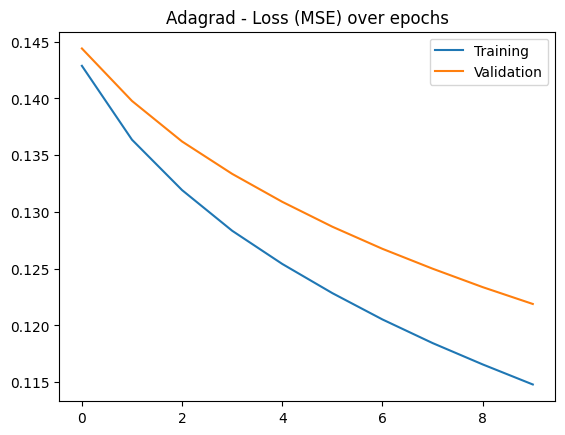

In [9]:
plt.plot(history_adagrad.history["loss"])
plt.plot(history_adagrad.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adagrad - Loss (MSE) over epochs")
plt.show()

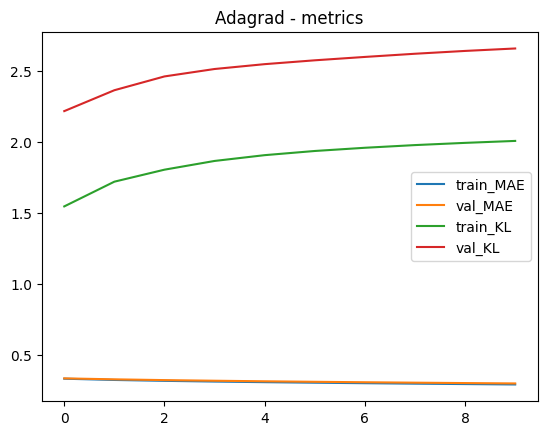

In [10]:
plt.plot(history_adagrad.history["MAE"])
plt.plot(history_adagrad.history["val_MAE"])
plt.plot(history_adagrad.history["kullback_leibler_divergence"])
plt.plot(history_adagrad.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("Adagrad - metrics")
plt.show()

RMSprop

In [8]:
autoencoder_RMSprop = Denoise()
autoencoder_RMSprop.compile(optimizer='RMSprop', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

In [9]:
history_RMSprop = autoencoder_RMSprop.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10


2023-01-23 20:43:03.432552: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 20:43:03.664443: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 35s 1s/step - loss: 0.0659 - kullback_leibler_divergence: 2.0078 - MAE: 0.1885 - val_loss: 0.0276 - val_kullback_leibler_divergence: 1.6123 - val_MAE: 0.1067 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 31s 956ms/step - loss: 0.0234 - kullback_leibler_divergence: 0.7165 - MAE: 0.0927 - val_loss: 0.0173 - val_kullback_leibler_divergence: 0.1871 - val_MAE: 0.0823 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.0151 - kullback_leibler_divergence: 0.1358 - MAE: 0.0810 - val_loss: 0.0134 - val_kullback_leibler_divergence: 0.1032 - val_MAE: 0.0832 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 32s 1s/step - loss: 0.0107 - kullback_leibler_divergence: 0.0972 - MAE: 0.0704 - val_loss: 0.0098 - val_kullback_leibler_divergence: 0.0994 - val_MAE: 0.0665 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 34s 1s/step - loss: 0.0095 - kullback_leibler_divergence: 0.1094

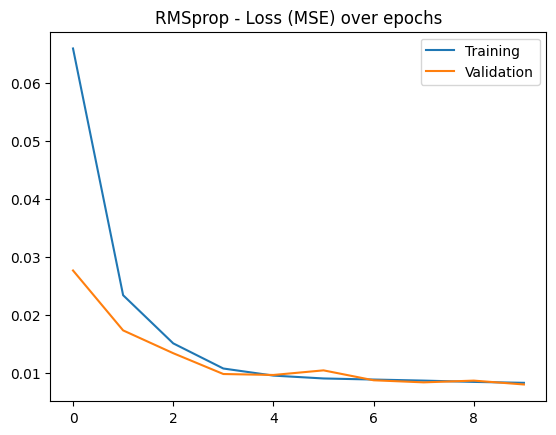

In [10]:
plt.plot(history_RMSprop.history["loss"])
plt.plot(history_RMSprop.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("RMSprop - Loss (MSE) over epochs")
plt.show()

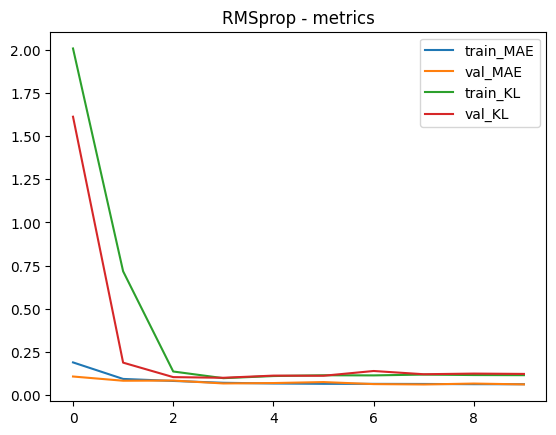

In [11]:
plt.plot(history_RMSprop.history["MAE"])
plt.plot(history_RMSprop.history["val_MAE"])
plt.plot(history_RMSprop.history["kullback_leibler_divergence"])
plt.plot(history_RMSprop.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("RMSprop - metrics")
plt.show()

SGD

In [6]:
autoencoder_SGD = Denoise()
autoencoder_SGD.compile(optimizer='SGD', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-23 20:53:09.409068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 20:53:09.409283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 20:53:09.409379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 20:53:09.409437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history_SGD = autoencoder_SGD.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10


2023-01-23 20:53:15.264049: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 20:53:15.522201: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 35s 1s/step - loss: 0.1333 - kullback_leibler_divergence: 2.0297 - MAE: 0.3216 - val_loss: 0.1202 - val_kullback_leibler_divergence: 2.5245 - val_MAE: 0.3000 - lr: 0.0100
Epoch 2/10
32/32 [==============================] - 31s 960ms/step - loss: 0.1108 - kullback_leibler_divergence: 2.1327 - MAE: 0.2868 - val_loss: 0.1060 - val_kullback_leibler_divergence: 2.5245 - val_MAE: 0.2739 - lr: 0.0100
Epoch 3/10
32/32 [==============================] - 31s 961ms/step - loss: 0.0985 - kullback_leibler_divergence: 2.1327 - MAE: 0.2644 - val_loss: 0.0988 - val_kullback_leibler_divergence: 2.5245 - val_MAE: 0.2570 - lr: 0.0100
Epoch 4/10
32/32 [==============================] - 31s 963ms/step - loss: 0.0920 - kullback_leibler_divergence: 2.1327 - MAE: 0.2496 - val_loss: 0.0955 - val_kullback_leibler_divergence: 2.5245 - val_MAE: 0.2468 - lr: 0.0100
Epoch 5/10
32/32 [==============================] - 33s 1s/step - loss: 0.0889 - kullback_leibler_divergence: 

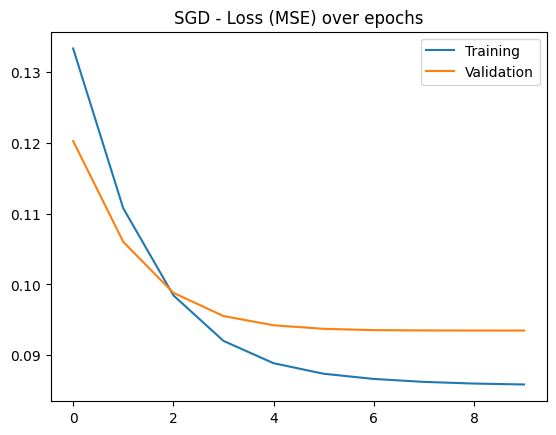

In [8]:
plt.plot(history_SGD.history["loss"])
plt.plot(history_SGD.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("SGD - Loss (MSE) over epochs")
plt.show()

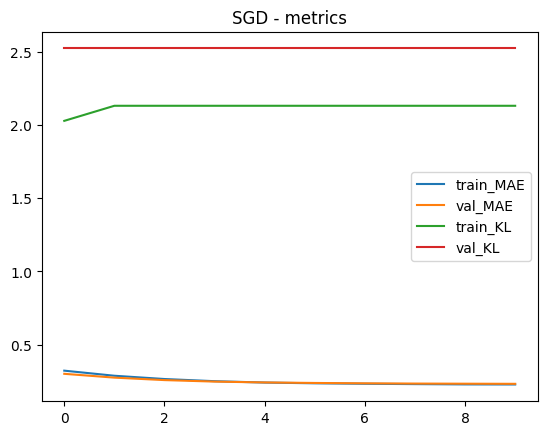

In [9]:
plt.plot(history_SGD.history["MAE"])
plt.plot(history_SGD.history["val_MAE"])
plt.plot(history_SGD.history["kullback_leibler_divergence"])
plt.plot(history_SGD.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.title("SGD - metrics")
plt.show()

---
## Testing different loss functions

In [6]:
autoencoder_adam_MAE = Denoise()
autoencoder_adam_MAE.compile(optimizer='adam', loss=losses.MeanAbsoluteError(), metrics=["kullback_leibler_divergence", "MSE", "logcosh"])

2023-01-23 21:47:59.146644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 21:47:59.146790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 21:47:59.146861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 21:47:59.146916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history_adam_MAE = autoencoder_adam_MAE.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10


2023-01-23 21:48:01.239500: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 21:48:01.468184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 36s 1s/step - loss: 0.2421 - kullback_leibler_divergence: 1.8515 - MSE: 0.0905 - logcosh: 0.0436 - val_loss: 0.1243 - val_kullback_leibler_divergence: 1.4607 - val_MSE: 0.0365 - val_logcosh: 0.0174 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 33s 1s/step - loss: 0.0912 - kullback_leibler_divergence: 0.5811 - MSE: 0.0194 - logcosh: 0.0094 - val_loss: 0.0712 - val_kullback_leibler_divergence: 0.1307 - val_MSE: 0.0115 - val_logcosh: 0.0057 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 32s 1s/step - loss: 0.0635 - kullback_leibler_divergence: 0.1431 - MSE: 0.0100 - logcosh: 0.0049 - val_loss: 0.0627 - val_kullback_leibler_divergence: 0.1329 - val_MSE: 0.0099 - val_logcosh: 0.0049 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 0.0600 - kullback_leibler_divergence: 0.1527 - MSE: 0.0094 - logcosh: 0.0046 - val_loss: 0.0612 - val_kullback_leibler_divergence: 0.1462 - val_MSE: 0

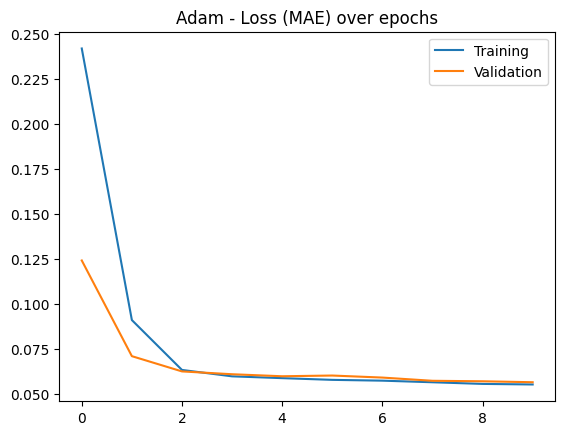

In [8]:
plt.plot(history_adam_MAE.history["loss"])
plt.plot(history_adam_MAE.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adam - Loss (MAE) over epochs")
plt.show()

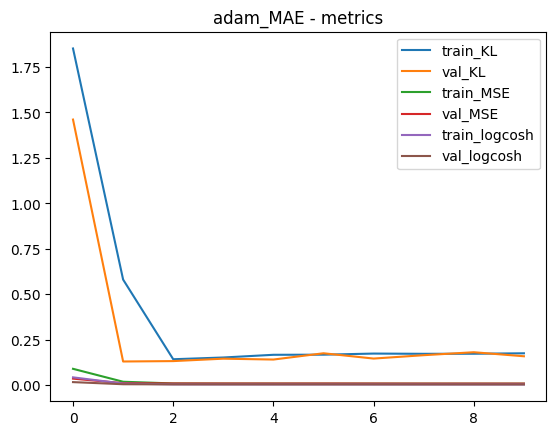

In [9]:
plt.plot(history_adam_MAE.history["kullback_leibler_divergence"])
plt.plot(history_adam_MAE.history["val_kullback_leibler_divergence"])
plt.plot(history_adam_MAE.history["MSE"])
plt.plot(history_adam_MAE.history["val_MSE"])
plt.plot(history_adam_MAE.history["logcosh"])
plt.plot(history_adam_MAE.history["val_logcosh"])
plt.legend(["train_KL", "val_KL", "train_MSE", "val_MSE", "train_logcosh", "val_logcosh"])
plt.title("adam_MAE - metrics")
plt.show()

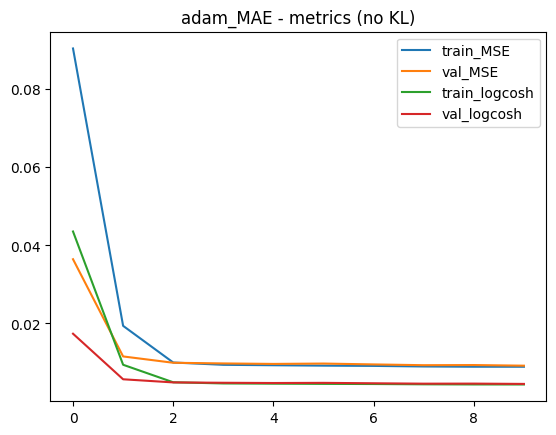

In [10]:
plt.plot(history_adam_MAE.history["MSE"])
plt.plot(history_adam_MAE.history["val_MSE"])
plt.plot(history_adam_MAE.history["logcosh"])
plt.plot(history_adam_MAE.history["val_logcosh"])
plt.legend(["train_MSE", "val_MSE", "train_logcosh", "val_logcosh"])
plt.title("adam_MAE - metrics (no KL)")
plt.show()

In [6]:
autoencoder_adam_logcosh = Denoise()
autoencoder_adam_logcosh.compile(optimizer='adam', loss=losses.LogCosh(), metrics=["kullback_leibler_divergence", "MAE", "MSE"])

2023-01-24 18:00:30.011393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-24 18:00:30.011534: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:00:30.011597: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:00:30.011648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history_adam_logcosh = autoencoder_adam_logcosh.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

2023-01-24 18:00:32.148553: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-24 18:00:32.346827: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/10
32/32 [==============================] - 37s 1s/step - loss: 0.0408 - kullback_leibler_divergence: 1.9222 - MAE: 0.2352 - MSE: 0.0845 - val_loss: 0.0152 - val_kullback_leibler_divergence: 1.1268 - val_MAE: 0.1230 - val_MSE: 0.0314 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 32s 991ms/step - loss: 0.0071 - kullback_leibler_divergence: 0.3171 - MAE: 0.0839 - MSE: 0.0144 - val_loss: 0.0059 - val_kullback_leibler_divergence: 0.2660 - val_MAE: 0.0695 - val_MSE: 0.0121 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 36s 1s/step - loss: 0.0043 - kullback_leibler_divergence: 0.1545 - MAE: 0.0619 - MSE: 0.0088 - val_loss: 0.0052 - val_kullback_leibler_divergence: 0.2207 - val_MAE: 0.0640 - val_MSE: 0.0107 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 0.0038 - kullback_leibler_divergence: 0.1132 - MAE: 0.0569 - MSE: 0.0077 - val_loss: 0.0045 - val_kullback_leibler_divergence: 0.1703 - val_MAE: 0.0576 - val_MS

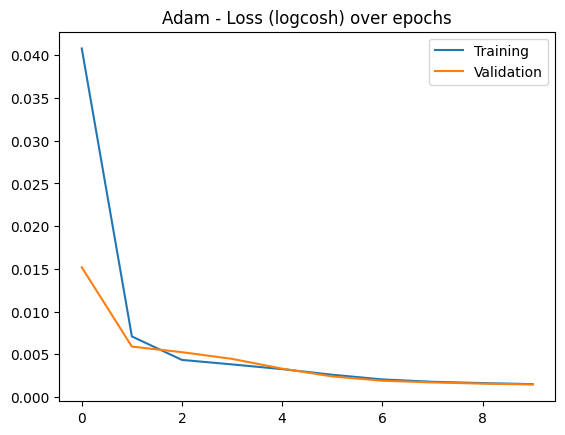

In [8]:
plt.plot(history_adam_logcosh.history["loss"])
plt.plot(history_adam_logcosh.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Adam - Loss (logcosh) over epochs")
plt.show()

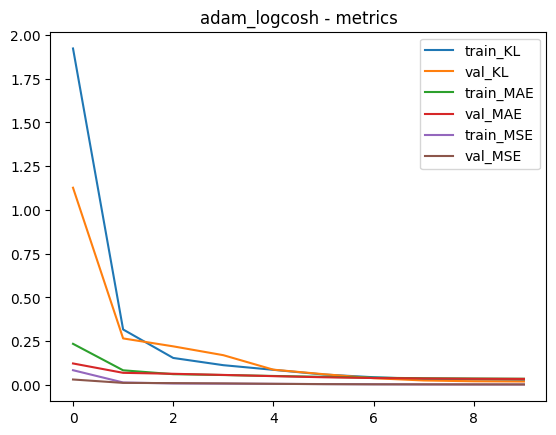

In [9]:
plt.plot(history_adam_logcosh.history["kullback_leibler_divergence"])
plt.plot(history_adam_logcosh.history["val_kullback_leibler_divergence"])
plt.plot(history_adam_logcosh.history["MAE"])
plt.plot(history_adam_logcosh.history["val_MAE"])
plt.plot(history_adam_logcosh.history["MSE"])
plt.plot(history_adam_logcosh.history["val_MSE"])
plt.legend(["train_KL", "val_KL", "train_MAE", "val_MAE", "train_MSE", "val_MSE"])
plt.title("adam_logcosh - metrics")
plt.show()

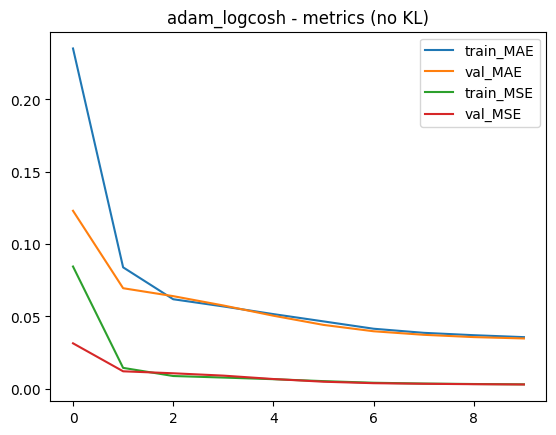

In [10]:
plt.plot(history_adam_logcosh.history["MAE"])
plt.plot(history_adam_logcosh.history["val_MAE"])
plt.plot(history_adam_logcosh.history["MSE"])
plt.plot(history_adam_logcosh.history["val_MSE"])
plt.legend(["train_MAE", "val_MAE", "train_MSE", "val_MSE"])
plt.title("adam_logcosh - metrics (no KL)")
plt.show()

In [6]:
autoencoder_RMSprop_MAE = Denoise()
autoencoder_RMSprop_MAE.compile(optimizer='RMSprop', loss=losses.MeanAbsoluteError(), metrics=["kullback_leibler_divergence", "MSE", "logcosh"])

2023-01-23 22:04:13.552106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 22:04:13.552264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 22:04:13.552337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 22:04:13.552412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history_RMSprop_MAE = autoencoder_RMSprop_MAE.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10


2023-01-23 22:04:25.630878: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 22:04:25.860281: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 35s 1s/step - loss: 0.2171 - kullback_leibler_divergence: 1.3148 - MSE: 0.0772 - logcosh: 0.0373 - val_loss: 0.0986 - val_kullback_leibler_divergence: 0.4870 - val_MSE: 0.0196 - val_logcosh: 0.0096 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.0771 - kullback_leibler_divergence: 0.2049 - MSE: 0.0127 - logcosh: 0.0062 - val_loss: 0.0685 - val_kullback_leibler_divergence: 0.1239 - val_MSE: 0.0108 - val_logcosh: 0.0053 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 34s 1s/step - loss: 0.0669 - kullback_leibler_divergence: 0.1174 - MSE: 0.0101 - logcosh: 0.0050 - val_loss: 0.0812 - val_kullback_leibler_divergence: 0.1066 - val_MSE: 0.0120 - val_logcosh: 0.0060 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 33s 1s/step - loss: 0.0637 - kullback_leibler_divergence: 0.1127 - MSE: 0.0095 - logcosh: 0.0047 - val_loss: 0.0657 - val_kullback_leibler_divergence: 0.1201 - val_MSE: 0

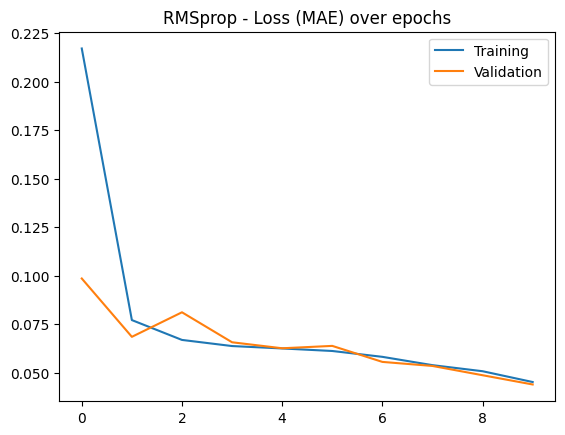

In [8]:
plt.plot(history_RMSprop_MAE.history["loss"])
plt.plot(history_RMSprop_MAE.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("RMSprop - Loss (MAE) over epochs")
plt.show()

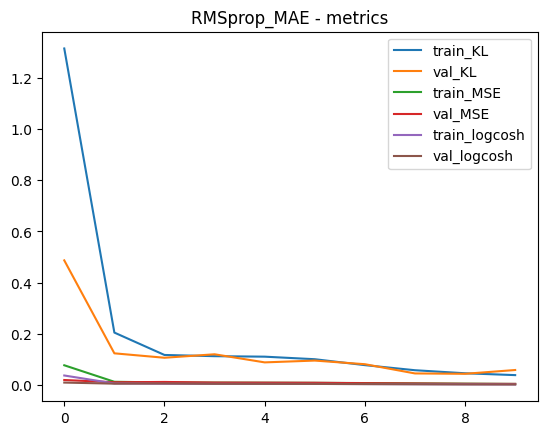

In [9]:
plt.plot(history_RMSprop_MAE.history["kullback_leibler_divergence"])
plt.plot(history_RMSprop_MAE.history["val_kullback_leibler_divergence"])
plt.plot(history_RMSprop_MAE.history["MSE"])
plt.plot(history_RMSprop_MAE.history["val_MSE"])
plt.plot(history_RMSprop_MAE.history["logcosh"])
plt.plot(history_RMSprop_MAE.history["val_logcosh"])
plt.legend(["train_KL", "val_KL", "train_MSE", "val_MSE", "train_logcosh", "val_logcosh"])
plt.title("RMSprop_MAE - metrics")
plt.show()

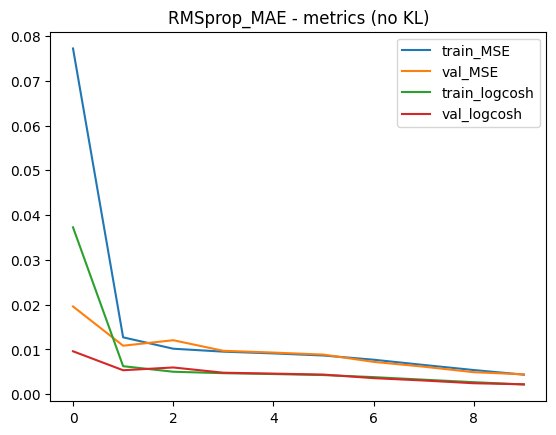

In [10]:
plt.plot(history_RMSprop_MAE.history["MSE"])
plt.plot(history_RMSprop_MAE.history["val_MSE"])
plt.plot(history_RMSprop_MAE.history["logcosh"])
plt.plot(history_RMSprop_MAE.history["val_logcosh"])
plt.legend(["train_MSE", "val_MSE", "train_logcosh", "val_logcosh"])
plt.title("RMSprop_MAE - metrics (no KL)")
plt.show()

In [6]:
autoencoder_RMSprop_logcosh = Denoise()
autoencoder_RMSprop_logcosh.compile(optimizer='RMSprop', loss=losses.LogCosh(), metrics=["kullback_leibler_divergence", "MAE", "MSE"])

2023-01-23 22:13:44.066288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-23 22:13:44.066417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 22:13:44.066475: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-23 22:13:44.066521: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history_RMSprop_logcosh = autoencoder_RMSprop_logcosh.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

Epoch 1/10


2023-01-23 22:13:45.941058: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-23 22:13:46.188133: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


32/32 [==============================] - 42s 1s/step - loss: 0.0315 - kullback_leibler_divergence: 2.0608 - MAE: 0.1894 - MSE: 0.0654 - val_loss: 0.0154 - val_kullback_leibler_divergence: 2.5185 - val_MAE: 0.1141 - val_MSE: 0.0321 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 41s 1s/step - loss: 0.0120 - kullback_leibler_divergence: 1.0285 - MAE: 0.0931 - MSE: 0.0251 - val_loss: 0.0126 - val_kullback_leibler_divergence: 0.5944 - val_MAE: 0.0960 - val_MSE: 0.0260 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 41s 1s/step - loss: 0.0107 - kullback_leibler_divergence: 0.3788 - MAE: 0.0883 - MSE: 0.0222 - val_loss: 0.0114 - val_kullback_leibler_divergence: 0.4420 - val_MAE: 0.0940 - val_MSE: 0.0235 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 34s 1s/step - loss: 0.0099 - kullback_leibler_divergence: 0.2921 - MAE: 0.0861 - MSE: 0.0204 - val_loss: 0.0111 - val_kullback_leibler_divergence: 0.3920 - val_MAE: 0.0985 - val_MSE: 0.0227 - lr

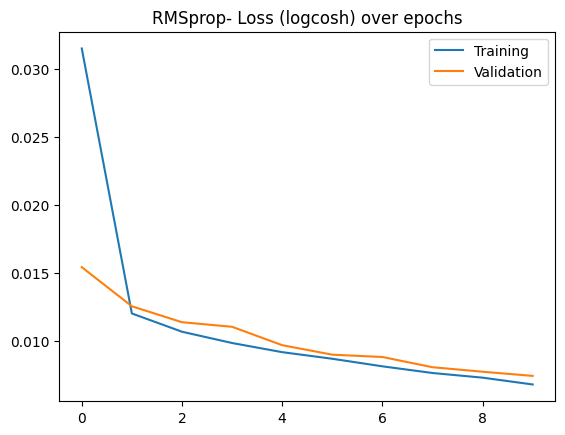

In [8]:
plt.plot(history_RMSprop_logcosh.history["loss"])
plt.plot(history_RMSprop_logcosh.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("RMSprop- Loss (logcosh) over epochs")
plt.show()

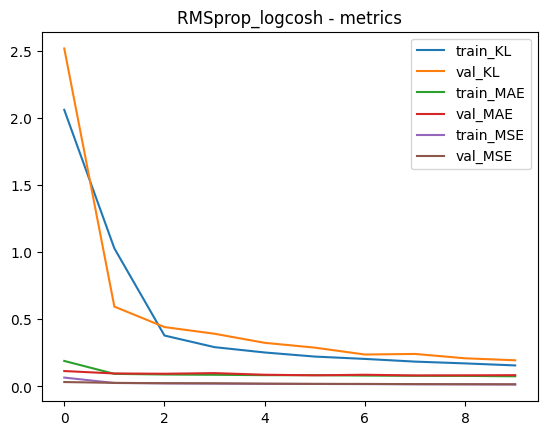

In [9]:
plt.plot(history_RMSprop_logcosh.history["kullback_leibler_divergence"])
plt.plot(history_RMSprop_logcosh.history["val_kullback_leibler_divergence"])
plt.plot(history_RMSprop_logcosh.history["MAE"])
plt.plot(history_RMSprop_logcosh.history["val_MAE"])
plt.plot(history_RMSprop_logcosh.history["MSE"])
plt.plot(history_RMSprop_logcosh.history["val_MSE"])
plt.legend(["train_KL", "val_KL", "train_MAE", "val_MAE", "train_MSE", "val_MSE"])
plt.title("RMSprop_logcosh - metrics")
plt.show()

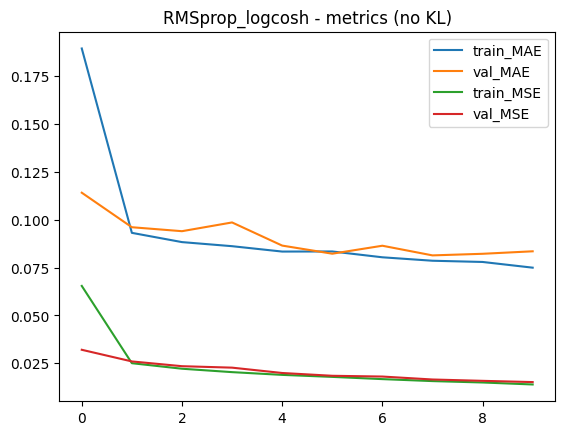

In [10]:
plt.plot(history_RMSprop_logcosh.history["MAE"])
plt.plot(history_RMSprop_logcosh.history["val_MAE"])
plt.plot(history_RMSprop_logcosh.history["MSE"])
plt.plot(history_RMSprop_logcosh.history["val_MSE"])
plt.legend(["train_MAE", "val_MAE", "train_MSE", "val_MSE"])
plt.title("RMSprop_logcosh - metrics (no KL)")
plt.show()